<a href="https://colab.research.google.com/github/iTosy/Approaches-of-Applying-Deep-Learning-in-Physical-Layer/blob/main/Binary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, Activation, Flatten, MaxPooling2D,Input,Dropout,GlobalAveragePooling2D
from keras import backend as K
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.layers import Layer
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.layers import BatchNormalization
from tensorflow.python.framework import ops

In [2]:
def binarize(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    '''
    clipped = K.clip(x,-1,1)
    rounded = K.sign(clipped)
    return clipped + K.stop_gradient(rounded - clipped)

In [3]:
class Residual_sign(Layer):
    def __init__(self, levels=1,**kwargs):
        self.levels=levels
        super(Residual_sign, self).__init__(**kwargs)
    def build(self, input_shape):
        ars=np.arange(self.levels)+1.0
        ars=ars[::-1]
        means=ars/np.sum(ars)
        self.means=[K.variable(m) for m in means]
        self._trainable_weights=self.means
    def call(self, x, mask=None):
        resid = x
        out_bin=0
        for l in range(self.levels):
            out=binarize(resid)*K.abs(self.means[l])
            out_bin=out_bin+out
            resid=resid-out
        return out_bin

    def get_output_shape_for(self,input_shape):
        return input_shape
    def compute_output_shape(self,input_shape):
		    return input_shape
    def set_means(self,X):
        means=np.zeros((self.levels))
        means[0]=1
        resid=np.clip(X,-1,1)
        approx=0
        for l in range(self.levels):
            m=np.mean(np.absolute(resid))
            out=np.sign(resid)*m
            approx=approx+out
            resid=resid-out
            means[l]=m
            err=np.mean((approx-np.clip(X,-1,1))**2)

        means=means/np.sum(means)
        sess=K.get_session()
        sess.run(self.means.assign(means))

In [4]:
class binary_conv(Layer):
	def __init__(self,nfilters,ch_in,k,padding,strides=(1,1),**kwargs):
		self.nfilters=nfilters
		self.ch_in=ch_in
		self.k=k
		self.padding=padding
		self.strides=strides
		super(binary_conv,self).__init__(**kwargs)
	def build(self, input_shape):
		stdv=1/np.sqrt(self.k*self.k*self.ch_in)
		w = np.random.normal(loc=0.0, scale=stdv,size=[self.k,self.k,self.ch_in,self.nfilters]).astype(np.float32)
		if keras.backend._backend=="mxnet":
			w=w.transpose(3,2,0,1)
		self.w=K.variable(w)
		self.gamma=K.variable(1.0)
		self.trainable_weights=[self.w,self.gamma]


	def call(self, x,mask=None):
		constraint_gamma=K.abs(self.gamma)#K.clip(self.gamma,0.01,10)
		self.clamped_w=constraint_gamma*binarize(self.w)
		if keras.__version__[0]=='2':
			self.out=K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides )
		if keras.__version__[0]=='1':
			self.out=K.conv2d(x,self.clamped_w,border_mode=self.padding,strides=self.strides)
		self.output_dim=self.out.get_shape()
		return self.out
	def  get_output_shape_for(self,input_shape):
		return (input_shape[0], self.output_dim[1],self.output_dim[2],self.output_dim[3])
	def compute_output_shape(self,input_shape):
		return (input_shape[0], self.output_dim[1],self.output_dim[2],self.output_dim[3])


In [5]:
class binary_dense(Layer):
	def __init__(self,n_in,n_out,**kwargs):
		self.n_in=n_in
		self.n_out=n_out
		super(binary_dense,self).__init__(**kwargs)
	def build(self, input_shape):
		stdv=1/np.sqrt(self.n_in)
		w = np.random.normal(loc=0.0, scale=stdv,size=[self.n_in,self.n_out]).astype(np.float32)
		self.w=K.variable(w)
		self.gamma=K.variable(1.0)
		self._trainable_weights=[self.w,self.gamma]

	def call(self, x,mask=None):
		constraint_gamma=K.abs(self.gamma)#K.clip(self.gamma,0.01,10)
		self.clamped_w=constraint_gamma*binarize(self.w)
		self.out=K.dot(x,self.clamped_w)
		return self.out
	def  get_output_shape_for(self,input_shape):
		return (input_shape[0], self.n_out)
	def compute_output_shape(self,input_shape):
		return (input_shape[0], self.n_out)

In [8]:
from keras.callbacks import EarlyStopping


bers = []

#Creating one-hot vector training dataset corresponding to binary message

Nt = 10000                                      #No. of messages
k = 3                                           #block size
M = 2**k                                        #one-hot vector size
label = np.random.randint(M,size=Nt)
data = []
for i in label:
  temp = np.zeros(M)
  temp[i] = 1
  data.append(temp)
data = np.array(data)                           #training dataset

#Creating Validation dataset

N_val = 1500
val_label = np.random.randint(M,size=N_val)
val_data = []
for i in val_label:
  temp = np.zeros(M)
  temp[i] = 1
  val_data.append(temp)
val_data = np.array(val_data)

#Creating testing dataset

N = 50000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
  temp = np.zeros(M)
  temp[i] = 1
  test_data.append(temp)

test_data = np.array(test_data)

#Create the corresponding binary model

for re in range(1,4):                 #residual levels M = 1,2,3
  BER = []

  #the model layers

  input = Input(shape=(8,))
  enco1 = binary_dense(n_in=8,n_out=8)(input)
  encor = Residual_sign(levels=re)(enco1)
  enco2 = binary_dense(n_in=8,n_out=7)(encor)

  norm = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-4)(enco2)

  EbNo_train = 10 ** (0.7)
  enco3 = keras.layers.GaussianNoise(np.sqrt(1/(2*(3/7)*EbNo_train)))(norm)     #train for SNR = 7 db

  deco1 = binary_dense(n_in=7,n_out=8)(enco3)
  decor = Residual_sign(levels=re)(deco1)
  deco2 = binary_dense(n_in=8,n_out=8)(decor)
  last = Activation('softmax')(deco2)

  opt = keras.optimizers.Adam(learning_rate=0.01,decay=1e-6)
  model = Model(input, last)
  model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

  model.fit(data, data,epochs=25,batch_size=300,validation_data=(val_data, val_data), callbacks=[EarlyStopping(restore_best_weights=True, patience=10)])


  #Encoder model
  encoder = Model(input, norm)

  #Receiver model
  encoded_input = Input(shape=(7,))

  decor = model.layers[-4](encoded_input)
  deco2 = model.layers[-3](decor)
  deco1 = model.layers[-2](deco2)
  deco = model.layers[-1](deco1)
  decoder = Model(encoded_input, deco)

  #Testing on SNR range

  SNRs = np.arange(-4,10.5,0.5)
  for snr in SNRs:
    EbNo=10.0**(snr/10.0)
    noise_std = np.sqrt(1/(2*(3/7)*EbNo))
    noise_mean = 0
    no_errors = 0
    noise = np.random.normal(0,noise_std,(N,7))
    encoded_signal = encoder.predict(test_data)
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    BER.append(no_errors / N)
  bers.append(BER)

Epoch 1/25
34/34 [==============================] - 2s 17ms/step - loss: 1.9017 - accuracy: 0.4093 - val_loss: 0.6812 - val_accuracy: 0.7647
Epoch 2/25
34/34 [==============================] - 0s 8ms/step - loss: 0.8138 - accuracy: 0.7431 - val_loss: 0.3983 - val_accuracy: 0.8860
Epoch 3/25
34/34 [==============================] - 0s 6ms/step - loss: 0.3868 - accuracy: 0.8596 - val_loss: 0.2097 - val_accuracy: 0.8860
Epoch 4/25
34/34 [==============================] - 0s 5ms/step - loss: 0.2380 - accuracy: 0.9047 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 5/25
34/34 [==============================] - 0s 6ms/step - loss: 0.1878 - accuracy: 0.9180 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 6/25
34/34 [==============================] - 0s 5ms/step - loss: 0.1828 - accuracy: 0.9245 - val_loss: 0.0907 - val_accuracy: 1.0000
Epoch 7/25
34/34 [==============================] - 0s 6ms/step - loss: 0.1996 - accuracy: 0.9230 - val_loss: 0.1028 - val_accuracy: 0.8860
Epoch 8/25
34/34 [=

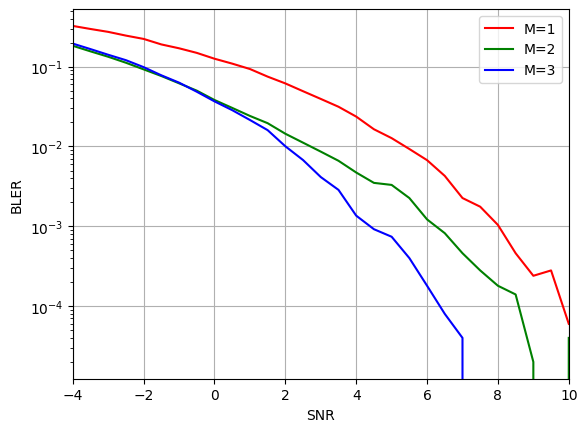

In [9]:
#Plotting curves for SNR and BLER for different residual level M

plt.figure()
plt.grid(True)
plt.xlim(-4,10)
plt.xlabel('SNR')
plt.ylabel('BLER')
plt.semilogy(SNRs, bers[0], c = 'r', label = 'M=1')
plt.semilogy(SNRs, bers[1], c = 'g', label = 'M=2')
plt.semilogy(SNRs, bers[2], c = 'b', label = 'M=3')
plt.legend(loc='best')